# Практическая часть семинара по композициям
Данные: соревнование [Mercedes-Benz Greener Manufacturing](https://www.kaggle.com/c/mercedes-benz-greener-manufacturing)

Данные загружаются сразу из гитхаба ниже.

Кратко о задаче: объекты - автомобили, целевая переменная - время, за которое автомобиль проходит тест, задача регрессии, качество измеряется с помощью $R^2$-метрики.

Скрипт загрузки и базовой предобработки данных взят с [Kaggle Kernels](https://www.kaggle.com/anokas/mercedes-eda-xgboost-starter-0-55/notebook). В этом же ядре приводится базовый exploration данных, можете почитать после семинара.



## Загрузка данных

In [1]:
import numpy as np
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import matplotlib
#import seaborn as sns
matplotlib.style.use('ggplot')
%matplotlib inline

In [2]:
df_train = pd.read_csv('https://raw.githubusercontent.com/nadiinchi/hse_cs_ml_course_2017_FTAD/master/materials/train.csv')
print('Size of training set: {} rows and {} columns'.format(*df_train.shape))
df_train.head()

Size of training set: 4209 rows and 378 columns


,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


Распределение целевого признака:

min: 72.11 max: 265.32 mean: 100.669318128 std: 12.6778749695
Count of values above 180: 1


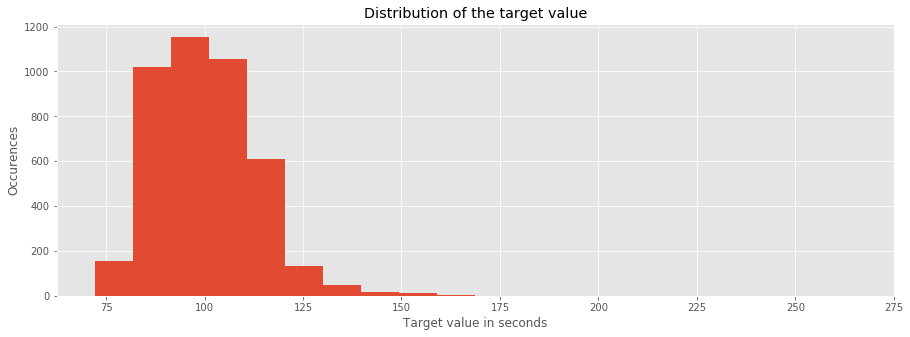

In [3]:
y_train = df_train['y'].values
plt.figure(figsize=(15, 5))
plt.hist(y_train, bins=20)
plt.xlabel('Target value in seconds')
plt.ylabel('Occurences')
plt.title('Distribution of the target value')

print('min: {} max: {} mean: {} std: {}'.format(min(y_train), max(y_train), y_train.mean(), y_train.std()))
print('Count of values above 180: {}'.format(np.sum(y_train > 200)))

Число признаков и объектов:

In [4]:
cols = [c for c in df_train.columns if 'X' in c]
print('Number of features: {}'.format(len(cols)))

print('Feature types:')
df_train[cols].dtypes.value_counts()

Number of features: 376
Feature types:


int64     368
object      8
dtype: int64

Приведение данных к вещественному виду:

In [5]:
usable_columns = list(set(df_train.columns) - set(['ID', 'y']))
y_train = df_train['y'].values
x_train = df_train[usable_columns]
for column in usable_columns:
    cardinality = len(np.unique(x_train[column]))
    if cardinality == 1:
        x_train.drop(column, axis=1) # Column with only one value is useless so we drop it
    if cardinality > 2: # Column is categorical
        mapper = lambda x: sum([ord(digit) for digit in x])
        x_train[column] = x_train[column].apply(mapper)
        
x_train.head()

/anaconda/envs/dataweekends/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,X189,X185,X184,X187,X186,X181,X180,X183,X182,X291,...,X96,X97,X98,X99,X204,X205,X202,X203,X200,X201
0,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,1,0,1,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,1,0,1,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,1,0,0,0,0


## Разделение данных
Разделим данные на три части. Первую будем использовать для настройки случайного леса и градиентного бустинга, вторую - для настройки композиции, третью - для итогового контроля.

In [6]:
x_train.shape, y_train.shape

((4209, 376), (4209,))

In [7]:
from sklearn.utils import shuffle

In [8]:
x_train, y_train = shuffle(x_train, y_train)

In [9]:
x1, y1 = x_train[:2000], y_train[:2000]
x1.shape, y1.shape

((2000, 376), (2000,))

In [10]:
x2, y2 = x_train[2000:3000], y_train[2000:3000]
x2.shape, y2.shape

((1000, 376), (1000,))

In [11]:
x3, y3 = x_train[3000:], y_train[3000:]
x3.shape, y3.shape

((1209, 376), (1209,))

## Настройка моделей

In [12]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, make_scorer
from sklearn.grid_search import GridSearchCV

//anaconda/envs/dataweekends/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
//anaconda/envs/dataweekends/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


В этой части вам надо найти оптимальные гиперпараметры для случайного леса и градиентного бустинга, используя первую часть выборки (x1, y1).

Начнем со случайного леса. 
1. (уже сделано ниже) Постройте график зависимости качества от числа деревьев в случайном лесе на кросс-валидации с 3 блоками. Выберите число деревьев для использования в дальнейшей настройке и при итоговом обучении модели.
1. Постройте график зависимости качества от max_features на кросс-валидации. Выберите оптимальное значение гиперпараметра.
1. С помощью кросс-валидации выберите оптимальные значения для max_depth, min_samples_leaf, min_samples_split.
1. Обучите случайный лес с выбранными гиперпараметрами на всей выборке x1, y1.

Указания: verbose=3 в GridSearchCV будет выводить значения качества на каждой обучаемой модели. Рекомендуется в экспериментах зафиксировать random_state у модели. 

In [14]:
param_grid = {"n_estimators":2**np.arange(10)} #  логарифмическая шкала
gs = GridSearchCV(RandomForestRegressor(random_state=1, warm_start=True), param_grid, make_scorer(r2_score))
#warmstart - говорит о том, что если на предыдущем шаге построили 100 дереьвев, а на следующем надо 150, то он берет уже построенные
#100 деревьев и обучает новые 50

In [15]:
gs.fit(x1, y1)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=True),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([  1,   2,   4,   8,  16,  32,  64, 128, 256, 512])},
       pre_dispatch='2*n_jobs', refit=True, scoring=make_scorer(r2_score),
       verbose=0)

In [16]:
gs.best_params_

{'n_estimators': 512}

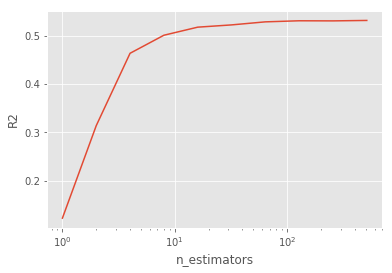

In [17]:
plt.plot((param_grid["n_estimators"]), [elem[1] for elem in gs.grid_scores_])
plt.xscale("log")
plt.xlabel("n_estimators")
plt.ylabel("R2")

Качество, как и ожидается, растет с увеличением числа базовых алгоритмов. Для валидации выберем 100 деревьев (быстро обучается и уже более-менее приналежит области стабильности качества), финальную модель будем обучать с 500 деревьями.

In [23]:
# базовая логарифмическая шкала для max_features
param_grid = {"max_features":2**np.arange(1, 9)}
gs1 = GridSearchCV(RandomForestRegressor(random_state=1, warm_start=True
                    , n_estimators=gs.best_params_['n_estimators'])
                   , param_grid, make_scorer(r2_score))
#warmstart - говорит о том, что если на предыдущем шаге построили 100 дереьвев, а на следующем надо 150, то он берет уже построенные
#100 деревьев и обучает новые 50

In [24]:
gs1.fit(x1, y1)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=512, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=True),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': array([  2,   4,   8,  16,  32,  64, 128, 256])},
       pre_dispatch='2*n_jobs', refit=True, scoring=make_scorer(r2_score),
       verbose=0)

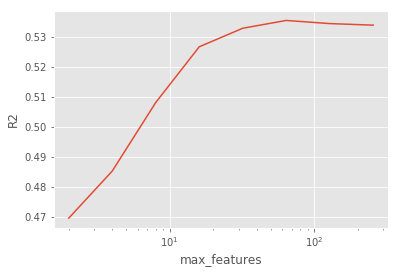

In [25]:
plt.plot((param_grid["max_features"]), [elem[1] for elem in gs1.grid_scores_])
plt.xscale("log")
plt.xlabel("max_features")
plt.ylabel("R2")

In [27]:
gs1.best_params_
#RF.fit(x1, y1)

{'max_features': 64}

In [28]:
# базовая шкала для остальных гиперпараметров
param_grid = {"max_depth":np.arange(1, 9, 2), "min_samples_leaf":[1, 3, 9, 27], "min_samples_split":[3, 9, 27, 81]}

gs2 = GridSearchCV(RandomForestRegressor(random_state=1, warm_start=True, n_estimators=gs.best_params_['n_estimators']
                                         , max_features = gs1.best_params_['max_features']), 
                                           param_grid, make_scorer(r2_score))
#warmstart - говорит о том, что если на предыдущем шаге построили 100 дереьвев, а на следующем надо 150, то он берет уже построенные
#100 деревьев и обучает новые 50

In [29]:
gs2.fit(x1, y1)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=64, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=512, n_jobs=1, oob_score=False, random_state=1,
           verbose=0, warm_start=True),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [3, 9, 27, 81], 'max_depth': array([1, 3, 5, 7]), 'min_samples_leaf': [1, 3, 9, 27]},
       pre_dispatch='2*n_jobs', refit=True, scoring=make_scorer(r2_score),
       verbose=0)

In [30]:
gs2.best_params_

{'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 81}

In [31]:
RF = gs2.best_estimator_ #возвращает алгоритм

Теперь настроим градиентный бустинг, используя ту же выборку x1, y1.

1. Запустите кросс-валидацию для GradentBoostingRegressor по n_estimators и learning_rate. Постройте двумерный график или несколько одномерных (например, график качество-число деревьев при разных значениях длины шага). Выберите значения для использования при дальнейшей настройке и для финального обучения модели.
1. Постройте график зависимости качества от max_depth на кросс-валидации.
1. Выберите оптимальные значения для min_samples_split, min_samples_leaf, max_features с помощью кросс-валидации.
1. Обучите итоговую модель с выбранными значениями гиперпараметров на всей выборке x1, y1.

Примеры построения трехмерных графиков [здесь](https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html).

In [33]:
# базовая шкала для числа деревьев и длины шага
param_grid = {"n_estimators":2**np.arange(10), "learning_rate":0.1**np.arange(5)}

gs = GridSearchCV(GradientBoostingRegressor(random_state=1, warm_start=True), 
                  param_grid, make_scorer(r2_score))

In [34]:
gs.fit(x1, y1)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=1,
             subsample=1.0, verbose=0, warm_start=True),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([  1,   2,   4,   8,  16,  32,  64, 128, 256, 512]), 'learning_rate': array([  1.00000e+00,   1.00000e-01,   1.00000e-02,   1.00000e-03,
         1.00000e-04])},
       pre_dispatch='2*n_jobs', refit=True, scoring=make_scorer(r2_score),
       verbose=0)

In [35]:
gs.best_params_

{'learning_rate': 0.010000000000000002, 'n_estimators': 512}

In [37]:
# базовая шкала для max_depth
param_grid = {"max_depth":np.arange(1, 9)}

gs1 = GridSearchCV(GradientBoostingRegressor(random_state=1, n_estimators=gs.best_params_['n_estimators'], 
                    learning_rate=gs.best_params_['learning_rate'], warm_start=True), param_grid, 
                       make_scorer(r2_score))
gs1.fit(x1, y1)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.010000000000000002, loss='ls', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=512,
             presort='auto', random_state=1, subsample=1.0, verbose=0,
             warm_start=True),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8])},
       pre_dispatch='2*n_jobs', refit=True, scoring=make_scorer(r2_score),
       verbose=0)

In [38]:
gs1.best_params_

{'max_depth': 2}

In [39]:
# базовая шкала для остальных гиперпараметров
param_grid = {"max_features":2**np.arange(1, 9, 2), "min_samples_leaf":[1, 3, 9, 27], 
              "min_samples_split":[3, 9, 27, 81]}

gs2 = GridSearchCV(GradientBoostingRegressor(random_state=1, max_depth=gs1.best_params_['max_depth'], 
                    n_estimators=gs.best_params_['n_estimators'], learning_rate=gs.best_params_['learning_rate'],
                    warm_start=True), param_grid, make_scorer(r2_score), verbose=3)
gs2.fit(x1, y1)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV] max_features=2, min_samples_split=3, min_samples_leaf=1 .........
[CV]  max_features=2, min_samples_split=3, min_samples_leaf=1, score=0.338366 -   0.3s
[CV] max_features=2, min_samples_split=3, min_samples_leaf=1 .........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  max_features=2, min_samples_split=3, min_samples_leaf=1, score=0.296139 -   0.2s
[CV] max_features=2, min_samples_split=3, min_samples_leaf=1 .........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV]  max_features=2, min_samples_split=3, min_samples_leaf=1, score=0.356927 -   0.2s
[CV] max_features=2, min_samples_split=9, min_samples_leaf=1 .........
[CV]  max_features=2, min_samples_split=9, min_samples_leaf=1, score=0.338460 -   0.2s
[CV] max_features=2, min_samples_split=9, min_samples_leaf=1 .........
[CV]  max_features=2, min_samples_split=9, min_samples_leaf=1, score=0.296222 -   0.2s
[CV] max_features=2, min_samples_split=9, min_samples_leaf=1 .........
[CV]  max_features=2, min_samples_split=9, min_samples_leaf=1, score=0.357099 -   0.2s
[CV] max_features=2, min_samples_split=27, min_samples_leaf=1 ........
[CV]  max_features=2, min_samples_split=27, min_samples_leaf=1, score=0.338330 -   0.2s
[CV] max_features=2, min_samples_split=27, min_samples_leaf=1 ........
[CV]  max_features=2, min_samples_split=27, min_samples_leaf=1, score=0.295833 -   0.2s
[CV] max_features=2, min_samples_split=27, min_samples_leaf=1 ........
[CV]  max_features=2, min_samples_split=27, min_sa

[Parallel(n_jobs=1)]: Done 192 out of 192 | elapsed:  2.1min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.010000000000000002, loss='ls', max_depth=2,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=512,
             presort='auto', random_state=1, subsample=1.0, verbose=0,
             warm_start=True),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': array([  2,   8,  32, 128]), 'min_samples_split': [3, 9, 27, 81], 'min_samples_leaf': [1, 3, 9, 27]},
       pre_dispatch='2*n_jobs', refit=True, scoring=make_scorer(r2_score),
       verbose=3)

In [40]:
gs2.best_params_

{'max_features': 128, 'min_samples_leaf': 9, 'min_samples_split': 27}

Выведите качество случайного леса и градиентного бустинга на x2, y2, а также качество модели, представляющей собой усреднение предсказаний двух обученных моделей.

In [41]:
GB = gs2.best_estimator_

In [45]:
#смотрим GB без параметров
GB_without_params = GradientBoostingRegressor()
GB_without_params.fit(x1, y1)
y_pred = GB_without_params.predict(x2)
r2_score(y2, y_pred)

0.49240254504200054

In [46]:
y_pred_GB = GB.predict(x2)
r2_score(y2, y_pred_GB)

0.48785646616084466

In [47]:
#смотрим RF без параметров
RF_without_params = RandomForestRegressor()
RF_without_params.fit(x1, y1)
y_pred = RF_without_params.predict(x2)
r2_score(y2, y_pred)

0.4289923752890451

In [48]:
y_pred_RF = RF.predict(x2)
r2_score(y2, y_pred_RF)

0.48465504358981615

Реализуйте блендинг. Обучите линейную регрессию на признаках - выходах двух моделей по выборке x2, y2. 

In [49]:
from sklearn.linear_model import LinearRegression

In [50]:
DF = pd.DataFrame(
    {'RF': y_pred_RF,
     'GB': y_pred_GB
    })

In [51]:
LR = LinearRegression()
LR.fit(DF, y2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Выведите качество случайного леса и градиентного бустинга на x3, y3, качество модели, представляющей собой усреднение предсказаний двух обученных моделей, а также качество блендинга.

In [52]:
y_pred_GB = GB.predict(x3)
print r2_score(y3, y_pred_GB)

y_pred_RF = RF.predict(x3)
print r2_score(y3, y_pred_RF)

y_pred_popolam = (y_pred_GB + y_pred_RF) / 2.0
print r2_score(y3, y_pred_popolam)

DF_test = pd.DataFrame(
    {'RF': y_pred_RF,
     'GB': y_pred_GB
    })
y_pred_LR = LR.predict(DF_test)
print r2_score(y3, y_pred_LR)

0.607227817634
0.609292505336
0.609543888663
0.605398188294


Что делать дальше (на выбор)
* Построить двухмерный график для бустинга :)
* Подобрать гиперпараметры более точно. Мы перебрали параметры только по грубой логарифмической шкале. На практике же перебор по более мелкой шкале может дать серьезный выигрыш в качестве. Сравнить итоговое качество на x2, y2 и x3, y3.
* Подобрать гиперпараметры для xgboost. Сравнить итоговое качество.
* Подобрать гиперпараметры для других моделей (например, линейной и метрической)
* Почитать на форуме соревнования, как его решали, и посмотреть Kernels.